## Evaluate Quality Data

### Importing

In [13]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt 
import obspy 

from window_slider import Slider

from pandas import read_csv, DataFrame, Series
from tqdm import tqdm
from andbro__save_to import __save_to
from andbro__fft import __fft


## pip install window-slider

### Initializing Settings

In [2]:
#plt.style.use('default') # print(plt.style.available)   

#%matplotlib inline

#mpld3.enable_notebook()

### Setting Variables

In [23]:
path = '/home/brotzer/Documents/ROMY/ROMY_QualityCheck/'


## interactively 
if len(sys.argv) > 1:
    date_to_analyse = sys.argv[1]
    channel = sys.argv[2]
else:
    date_to_analyse =input("\n Enter the date (e.g. 2019-05-14):  "); print("\n")
    channel = input("\n Enter the date (e.g. 2019-05-14):  "); print("\n")

## manually
# date_to_analyse = '2019-11-11'
# channel = 'BJZ'

date_to_analyse = obspy.UTCDateTime(date_to_analyse)

## setting input paths and files automatically
ipath = f'{path}Qfiles/{str(date_to_analyse)[:7]}/'
ifile = f'{date_to_analyse.date}.Q{channel[-1]}'

opath = f'{path}Cfiles/{str(date_to_analyse)[:7]}/'
ofile = f'{date_to_analyse.date}.C{channel[-1]}'

opathfigs = f'{path}Qplots/{str(date_to_analyse)[:7]}/'
onamefigs = f'ROMY_{date_to_analyse.date}_Q{channel[-1]}plots'


global date; date = ifile[:10]

global component; component = f"{channel[2]}-Component"


if not os.path.isfile(ipath+ifile):
    print(f"\nNo input file found: {ipath+ifile}")
    sys.exit()

TypeError: an integer is required (got type str)

### Define Methods

In [4]:

def __archive_request(seed_id, tstart, tdelta, raw=None):
    
    ''' get data of ROMY for one component from archive 

    VARIABLES:
        seed_id:    code of seismic stations (e.g. "BW.ROMY..BJU")
        tstart:	    begin of time period
        tdelta:     temporal length of period

    DEPENDENCIES:
        import obspy

    EXAMPLE:
        >>> __get_stream_data_archive('BW.ROMY.10.BJZ', '2020-07-17 02:50', 3600, raw=False)

    '''
    from obspy.clients.fdsn import Client

#     print(" requesting data from archive...")

    net, sta, loc, cha = seed_id.split(".")
    
    ## defining parameters
    year = tstart.year
    doy  = tstart.julday
    tend = tstart + tdelta
    
    ## define station depending if raw is set or not
#     sta = sta if raw is None else f"D{sta}"

    ## define local data path
    pathroot = "/import/freenas-ffb-01-data/romy_archive/"

    ## __________________________________________________________________________
    
    try:
        route = obspy.clients.fdsn.RoutingClient("eida-routing")
        inv   = client.get_stations(network=net, station=sta, level="response")
#         print("  --> inventory was obtained"); obtained_inventory=True

    except:
        if raw is not True:
            print("  --> inventory could not be obtained..."); obtained_inventory=False
    
    ## -------------------------- ##
    if raw is None or raw is False:
        ## recreate file structure of archive
        path = f"{pathroot}{year}/{net}/{sta}/{cha}.D/"
        name = f"{net}.{sta}.{loc}.{cha}.D.{year}.{doy}"
        ## get stream data
        st = obspy.read(path+name, starttime=tstart, endtime= tend)
        
        if obtained_inventory:
            print("  --> trend and response is being removed...")
            return st.detrend("linear").remove_response(inventory=inv) 
        else:
            return st   

    ## -------------------------- ##
    elif raw is True: 
        if sta == "ROMY":
            ## recreate file structure of archive
            path = f"{pathroot}{year}/{net}/DROMY/FJ{cha[2]}.D/"
            name = f"{net}.D{sta}..F{cha[1:3]}.D.{year}.{doy}"
            ## get stream data
            st = obspy.read(path+name, starttime=tstart, endtime= tend)
            return st
        else:
            print("  --> something went wrong! perhaps with seed_id?")


In [5]:

def __evaluate_quality(trace, opath):
    
#     print(" evaluating data...")
    
    samples = trace[0].stats.npts
    deltaT  = trace[0].stats.delta
    steps = int(60 / deltaT) # every minute


    intervalls = np.arange(0,samples,steps)

    minute_axis = np.arange(steps/2,samples-steps/2,steps) 
    minute_axis_time = []
    for l in minute_axis:
        minute_axis_time.append(trace[0].times()[int(l)])

    ## allocate memory for variables

    delta_min    = np.zeros(len(intervalls[:-1]))
    delta_max    = np.zeros(len(intervalls[:-1]))
    sigma_minute = np.zeros(len(intervalls[:-1]))
    mean_minute  = np.zeros(len(intervalls[:-1]))
    ifreq        = np.zeros(len(intervalls[:-1]))

    
    for k, idx in enumerate(range(0,len(intervalls[:-1]))):
            x = trace[0][intervalls[idx]:intervalls[idx+1]]
#             print(intervalls[idx]*deltaT/60,"min", "-", intervalls[idx+1]*deltaT/60, "min")

            Nseconds = 2 # every 2 seconds
            binsize = Nseconds / deltaT 
            overlap = int(binsize/4)


            bins=np.arange(binsize/2, len(x)-binsize/2+overlap, overlap)

            ## allocate variable memory
            dif_tmp   = np.zeros(len(bins))
            avg_tmp   = np.zeros(len(bins))
            std_tmp   = np.zeros(len(bins))
            ifreq_tmp = np.zeros(len(bins))

            for l, xbin in enumerate(bins):

                wdata=x[int(xbin-binsize/2):int(xbin+binsize/2)]

                avg_tmp[l] = (np.mean(wdata))

                std_tmp[l] = (np.std(wdata))

                dif_tmp[l] = (np.abs(np.max(wdata))-np.abs(np.min(wdata)))

                ifreq_tmp[l] = (np.nonzero(np.diff(wdata-np.mean(wdata) > 0))[0].size) /2 /Nseconds
        

            ## assign values to vectors
            mean_minute[k] = (np.mean(avg_tmp))
            sigma_minute[k] = (np.std(std_tmp))
            delta_max[k] = (np.max(dif_tmp))
            delta_min[k] = (np.min(dif_tmp))
            ifreq[k] = np.mean(ifreq_tmp)
            
            del avg_tmp, std_tmp, dif_tmp, ifreq_tmp
    
    ## calulcate offset to add for each iteration (time and samples) 
    toffset = trace[0].stats.starttime.time.hour*3600+trace[0].stats.starttime.time.minute*60+trace[0].stats.starttime.time.second
    soffset = toffset/trace[0].stats.delta
    
    ## create output filename
    oname = f"{trace[0].stats.starttime.date}.Q"
    
    ## writing output
    out = open(opath + oname, "a+")
    
    for idx in range(0,len(minute_axis)):
        out.write(f"{soffset+minute_axis[idx]} {toffset+minute_axis_time[idx]} {mean_minute[idx]} {sigma_minute[idx]} {delta_max[idx]} {delta_min[idx]} {ifreq[idx]}\n")
    out.close()


In [6]:

def __plot_quality(data, data_quality, criteria=None, limit=False):

    t1 = "00:00"
    t2 = "24:00"
    
    
    ## calulcate difference in samples from first and second row in dataframe
    idx1 = data[data['sample_id'] == data.sample_id.iloc[0]].index[0]
    idx2 = data[data['sample_id'] == data.sample_id.iloc[1]].index[0]
    steps = int(abs(data.sample_id.iloc[0]-data.sample_id.iloc[1])/(idx2-idx1))

    ## plotting 
    fig, axes = plt.subplots(6, 1, figsize=(15,12), sharex='all')

    fig.subplots_adjust(hspace=0.2)

    fs=14

    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.average

    if limit:
        # axes[0].scatter(xdata, ydata, s=35, label='mean', color="darkblue", edgecolor="black", zorder=3)
        axes[0].errorbar(xdata, ydata, yerr=data.sigma, label='mean', ecolor='grey', markeredgewidth=0.1 ,fmt="ok", capsize=5)
        axes[0].plot(xdata, ydata, 'k--')
    else:
        axes[0].plot(xdata, ydata, 'k-', label='mean')

    
    axes[0].legend(fontsize=fs, loc="upper left")
    axes[0].tick_params(axis='both', labelsize=fs)
    axes[0].set_xlim(0,24)
    
    if criteria:
        axes[0].set_title(f"Raw data of {component} on {date} with thresholds", fontsize=fs+3)
    else:
        axes[0].set_title(f"Raw data of {component} on {date} after selection", fontsize=fs+3)
    
    ## _______________________________________________________________________________
    xdata, ydata  = data.seconds/3600, data.daverage

    if limit:
        axes[1].scatter(xdata, ydata, s=35, label='dt_mean', color="red", edgecolor="black", linewidth=0.5 ,zorder=3)
#         axes[1].plot(xdata, ydata, 'k--')
    else:
        axes[1].plot(xdata, ydata, 'r-', label='dt_mean') 
        
    if criteria:
        axes[1].plot(xdata, np.ones(len(ydata))*davg_crt, color='darkgrey', linestyle="--", label=f'{round(davg_crt,1)}')

        
    axes[1].legend(fontsize=fs, loc="upper left")
    axes[1].tick_params(axis='both', labelsize=fs)
    axes[1].set_xlim(0,24)



    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.sigma

    if limit:
        axes[2].scatter(xdata, ydata, s=35, label='std', color="darkorange", edgecolor="black", linewidth=0.5 ,zorder=3)
#         axes[2].plot(xdata, ydata, 'k--')
    else:
        axes[2].plot(xdata, ydata, color='darkorange', label='std')

    if criteria: 
        axes[2].plot(xdata, np.ones(len(ydata))*sigma_crt, color='darkgrey', linestyle="--", label=f'{round(sigma_crt,1)}')
#         axes[2].plot(xdata, np.ones(len(ydata))*np.median(ydata), color='darkgrey', linestyle="--", label='median')

    axes[2].legend(fontsize=fs, loc="upper left")
    axes[2].tick_params(axis='both', labelsize=fs)
    axes[2].set_xlim(0,24)



    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.frequency

    if limit:
        axes[3].scatter(xdata, ydata, s=35, label='frequency', color="green", edgecolor="black", linewidth=0.5 ,zorder=3)
#         axes[3].plot(xdata, ydata, 'k--')
    else:
        axes[3].plot(xdata, ydata, color='green', label='frequency')
    
    if criteria:
        axes[3].plot(xdata, np.ones(len(ydata))*f1_crt, color='darkgrey', linestyle="--", label=f'{f1_crt}')
        axes[3].plot(xdata, np.ones(len(ydata))*f2_crt, color='darkgrey', linestyle="--", label=f'{f2_crt}')


    axes[3].legend(fontsize=fs, loc="upper left")
    axes[3].tick_params(axis='both', labelsize=fs)
    axes[3].set_xlim(0,24)
   
  
    
    if np.median(ydata) < f2_crt and np.median(ydata) > f1_crt:
        axes[3].set_ylim(np.median(ydata) - 1e-3*np.median(ydata), np.median(ydata) + 1e-3*np.median(ydata))


    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, data.delta_max/data.average
    if limit:
        axes[4].scatter(xdata, ydata, s=8, label='AC/DC max', color="darkblue", zorder=3)
#         axes[4].plot(xdata, ydata, 'k--')
    else:
        axes[4].plot(xdata, ydata, color='darkblue', label='AC/DC max')

    xdata, ydata = data.seconds/3600, data.delta_min/data.average
    if limit:
        axes[4].scatter(xdata, ydata, s=8, label='AC/DC min', color="darkred", zorder=3)
#         axes[4].plot(xdata, ydata, 'k--'), linewidth=0
    else:
        axes[4].plot(xdata, ydata, color='darkred', label='AC/DC min')
   
    if criteria:
        axes[4].plot(xdata, np.ones(len(ydata))*ratio_crt, color='darkgrey', linestyle="--", label=f'{round(ratio_crt,1)}')
        

    axes[4].legend(fontsize=fs, loc="upper left")
    axes[4].tick_params(axis='both', labelsize=fs)
    axes[4].set_xlim(0,24)


    ## _______________________________________________________________________________
    xdata, ydata = data.seconds/3600, (data.delta_max-data.delta_min)/data.average
    if limit:
        axes[5].scatter(xdata, ydata, s=8, label='Delta AC/DC', color="purple", zorder=3)
#         axes[5].plot(xdata, ydata, 'k--')
    else:
        axes[5].plot(xdata, ydata, color="purple", label='Delta AC/DC')

    if criteria:
        axes[5].plot(xdata, np.ones(len(ydata))*amp_crt, color='darkgrey', linestyle="--", label=f'{round(amp_crt,1)}')


    axes[5].legend(fontsize=fs, loc="upper left")
    axes[5].tick_params(axis='both', labelsize=fs)
    axes[5].set_xlabel("Time (hours)", fontsize=fs)
    axes[5].set_xlim(0,24)

    
    
    if limit:
        plt.xlim((int(t1[:2])*3600 + int(t1[3:5]))/3600,(int(t2[:2])*3600 + int(t2[3:5]))/3600)
    else:
        axes[5].set_xticks(np.arange(0,25,2))
        axes[5].set_xticklabels(np.arange(0,25,2))

        
    ## Add colored areas indicating quality    
#     data3=data[(data['gaps'] != 0) | (data.seconds == 86370.0)]
    data3=data_quality
    
    for i in range(len(data3)-1): 
#     print(data3.iloc[i, 1], data3.iloc[i+1, 1])     
    

        if data3.iloc[i,9] == 0:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='green' ,alpha=0.4, lw=0.001, edgecolor=None);  
        if data3.iloc[i,9] == 1:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='yellowgreen' ,alpha=0.5, lw=0.001, edgecolor=None);  
        if data3.iloc[i,9] == 2:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='lightcoral' ,alpha=0.5, lw=0.001, edgecolor=None);  
        if data3.iloc[i,9] == 3:
            for h in range(6):
                axes[h].axvspan(data3.iloc[i,1]/3600, data3.iloc[i+1,1]/3600, facecolor='darkred' ,alpha=0.3, lw=0.001, edgecolor=None);     

    
#     plt.show();
    return fig


### Load Data

In [7]:


## read data from file to dataframe
data = read_csv(ipath+ifile, delimiter=" ", header=1)


## add data colmuns
data['diff'] = (data.delta_max - data.delta_min)/data.average

data['daverage'] = data.average.diff().shift(-1).abs()
data.daverage = data.daverage/max(data.daverage)


## show head of dataframe
data.head()
data.size


,sample_id,seconds,average,sigma,delta_max,delta_min,frequency,diff,daverage
0,150000.0,30.0,1.683636e+06,67.344470,642952.0,630523.0,548.454167,0.007382,0.003556
1,450000.0,90.0,1.683656e+06,63.117141,648183.0,631448.0,548.641667,0.009940,0.025146
2,750000.0,150.0,1.683802e+06,73.361198,645030.0,629084.0,548.645833,0.009470,0.018146
3,1050000.0,210.0,1.683906e+06,71.363698,646754.0,631732.0,548.675000,0.008921,0.047864
4,1350000.0,270.0,1.683630e+06,60.294726,648013.0,629247.0,548.645833,0.011146,0.015710


12960

### Manipulate Data

In [8]:

# ## __________________________________
if (data.daverage.max()-data.daverage.min()) > (data.daverage.median() + data.daverage.std()*3):
    davg_crt = data.daverage.median() + data.daverage.std() * 5
else:
    davg_crt = data.daverage.median() + data.daverage.std() * 3

data['quality'] = np.where(data['daverage'] < davg_crt, 0, 3)


# ## __________________________________
f1_crt, f2_crt = 553.1, 553.7
data['quality'] = np.where((data['frequency'] < f2_crt) & (data['frequency'] > f1_crt), data['quality'], 3 )


# ## __________________________________
sigma_crt = data.sigma.median() + data.sigma.std() * 3
data['quality'] = np.where((data['quality'] < 3) & (data['sigma'] > sigma_crt) , 2, data['quality'])


# ## __________________________________
ratio_crt = 1.0 
data['quality'] = np.where((data['quality'] < 2)  & ((data.delta_max/data.average) < ratio_crt) , 1, data['quality'])
data['quality'] = np.where((data['quality'] < 2)  & ((data.delta_min/data.average) < ratio_crt) , 1, data['quality'])


# ## __________________________________
amp_crt = data['diff'].median() + data['diff'].std() 
data['quality'] = np.where((data['quality'] < 2) & (data['diff'] > amp_crt) , 1, data['quality'])

## check for changes in quality for ample coloring
data['gaps'] = data.quality.diff()
## exchane NaN (due to diff) for 1.0 
data.iloc[0,10] = 1.0



# print(f"{ifile[:10]}\n\n Q0: {round(a*100,2)}%\n Q1: {round(b*100,2)}%\n Q2: {round(d*100,2)}%\n Q3: {round(c*100,2)}%")
qlevel = np.unique(data.quality, return_counts=True)
print(f"{ifile[:10]}")
for j in range(len(qlevel[0])):
    print(f"Q{qlevel[0][j]}:  {round(qlevel[1][j]/len(data.quality)*100, 2)}%") 

    
# ## select good quality data
data_select  = data[(data['quality'] == 0) | (data['quality'] == 1)]
data_quality = data[(data['gaps'] != 0)]

## always add last row to selection
data_quality = data_quality.append(data.iloc[-1][:])


if data_select.empty:
    print("fuck, all data sucks!")
    sys.exit()

    
# data_quality[data_quality['gaps'] == 1]

2019-11-01
Q1:  0.07%
Q3:  99.93%


### Plotting

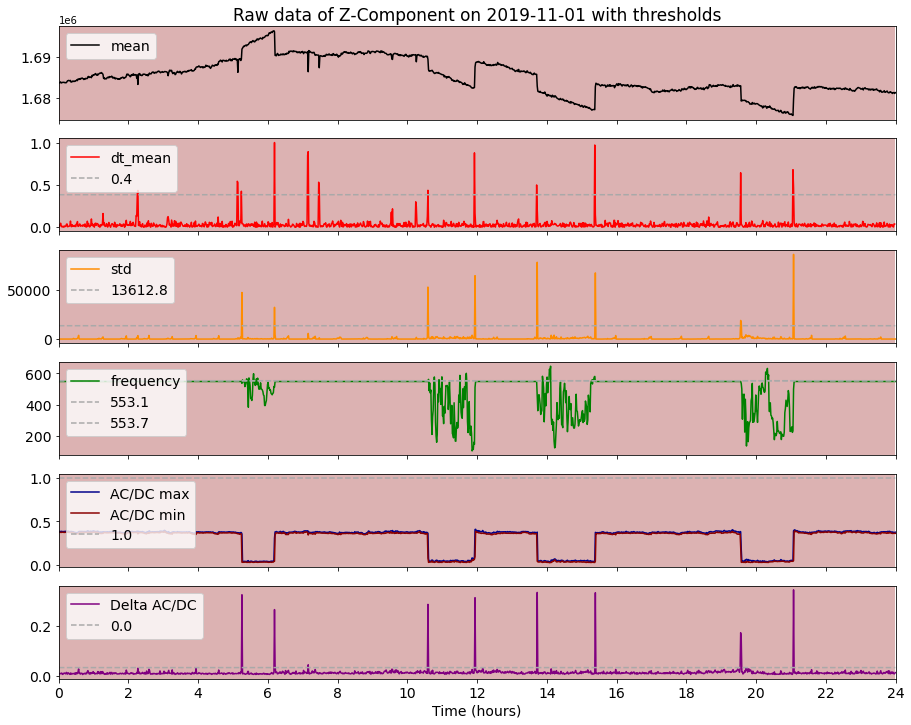

In [9]:

fig1 = __plot_quality(data, data_quality, criteria=True, limit=False)

if len(data_select) > 1:
    fig2 = __plot_quality(data_select, data_quality, criteria=False, limit=True)


### Writing Data and Save Figures

In [14]:
## save figures
if not os.path.isdir(opathfigs):
    os.mkdir(opathfigs)

if len(data_select) > 1:
    __save_to([fig1, fig2], outpath=opathfigs, outname=onamefigs, mode="pdf") 
else:
    __save_to(fig1, outpath=opathfigs, outname=onamefigs, mode="pdf") 
    
    
## create output file and add header
if not os.path.isdir(opath):
    os.mkdir(opath)
data_quality.to_csv(f'{opath}{ofile}', header=True, index=True, columns=['seconds','quality'])



 --> saving pdf to /home/brotzer/Documents/ROMY/ROMY_QualityCheck/Qplots/ROMY_2019-11-01_Qplots.pdf... 


* Done

